In [ ]:
#@title Install prerequsite

!pip install scikit-allel
!pip install biopython
!pip install ipytree
!pip install pysam
!pip install pyvcf
!pip install zarr
!pip install numcodecs

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Set data file location
# If you are running notebooks on your laptop, change this to the directory
# where you put downloaded files

from pathlib import Path

DATA = Path("")

## Sequencing file format

In this section, we'll demonstrate basic sequencing file manipulation using `Biopython` and `pysam`. Note `pysam` must be installed through `bioconda` channel and __is not available on Windows machine__. You will need to use a Linux virtual machine or Ubuntu kernel to run it.

### Read FASTQ files

`FASTQ` files are structurally very similar to `FASTA` files, only that it also contains quality scores for each base in the sequence.

We will load the pair-end reads from one subject `HG03078` from 1000 genome. 
First, let's take a look at how the file looks like in text mode

In [ ]:
!head -n 12 /content/drive/My\ 

@SRR591844.1 1/1
TTAGGGTTGGGGCTGGGGTGGGGGCGGGGGCGGGGGCGGGGGCGAGGTTTAGGGTTAGGGTTAGGGGTTAGGGGTA
+
1==A;A2<007A)@AA############################################################
@SRR591844.2 2/1
AGCACAAGCACTACTTACTGGCCTAGGTTGTGAGAGAAGTTGATCCTCTCACTCATCTTTCCTCCAATCTTTCCCC
+
CCCFFFFFHGHHHJJJJJJJIJJJJJJFHJIJJJJJJJIJJJJJJJJJJGIIJJJIIJJJJJIJGFHGIJJJJJHC
@SRR591844.3 3/1
AGCGAGGGCCGGCCACGTATCACAGCCAAGGAGATGAGCACAAGCACTACTTACTGGCCTAGGTTGTGAGAGAAGT
+
@@@FDDDD@CFDFHGIIHGHHIJGIIJI;FHGHGIJFIHIJGGGHHGEBCE@BDEC:;AEA?ACCD=<CCCC?CC>


In [ ]:
from Bio import SeqIO

In [ ]:
# change this path according to your local path setting
fastq1_path = DATA / "SRR591844_1.filt.fastq"
fastq2_path = DATA / "SRR591844_2.filt.fastq"

fastq1 = SeqIO.parse(fastq1_path, "fastq")
fastq2 = SeqIO.parse(fastq2_path, "fastq")

paired = zip(fastq1, fastq2)

In [ ]:
rec1, rec2 = next(paired)

In [ ]:
print("rec1 ID: {}\nrec2 ID: {}".format(rec1.id, rec2.id))

rec1 ID: SRR591844.1
rec2 ID: SRR591844.1


Same id indicates they are paired

The quality score of `FASTQ` is in the `phred_quality` field of the `letters_annotation` attribute.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'phred_quality')

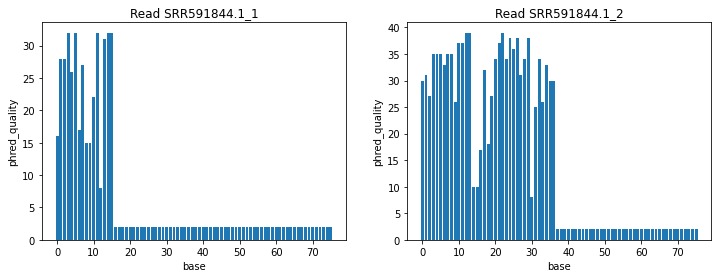

In [ ]:
fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axarr[0].bar(np.arange(len(rec1)), rec1.letter_annotations["phred_quality"])
axarr[0].set_title("Read {}_1".format(rec1.id))
axarr[0].set_xlabel("base")
axarr[0].set_ylabel("phred_quality")

axarr[1].bar(np.arange(len(rec2)), rec2.letter_annotations["phred_quality"])
axarr[1].set_title("Read {}_2".format(rec2.id))
axarr[1].set_xlabel("base")
axarr[1].set_ylabel("phred_quality")

Genrally the Phred quality score was calculated by 
$$-10\log_{10}(p)$$
where p is the probability of calling base incorrectly. Therefore, a general rule of thumb would set the Phred score threshold to 20.

The quality of the latter half of both reads seem to be quite low. Let's see the next read pair.

In [ ]:
rec1, rec2 = next(paired)

In [ ]:
print("rec1 ID: {}\nrec2 ID: {}".format(rec1.id, rec2.id))

rec1 ID: SRR591844.2
rec2 ID: SRR591844.2


Text(0, 0.5, 'phred_quality')

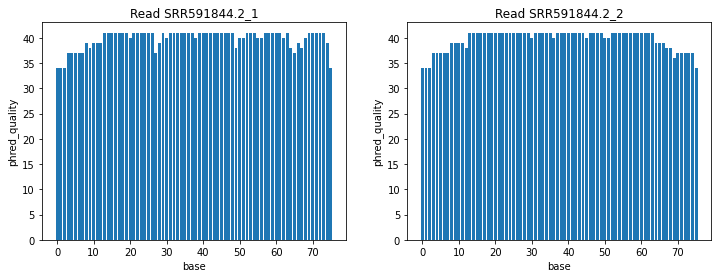

In [ ]:
fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axarr[0].bar(np.arange(len(rec1)), rec1.letter_annotations["phred_quality"])
axarr[0].set_title("Read {}_1".format(rec1.id))
axarr[0].set_xlabel("base")
axarr[0].set_ylabel("phred_quality")

axarr[1].bar(np.arange(len(rec2)), rec2.letter_annotations["phred_quality"])
axarr[1].set_title("Read {}_2".format(rec2.id))
axarr[1].set_xlabel("base")
axarr[1].set_ylabel("phred_quality")

Let's do a quick filtering to remove all read pairs where at least one read has a minimum Phred score below 20.

In [ ]:
fastq1 = SeqIO.parse(fastq1_path, "fastq")
fastq2 = SeqIO.parse(fastq2_path, "fastq")

# quality score threshold
phred_threshold = 20

total_pair_count = 0
filtered_pair_count = 0

for seq1, seq2 in zip(fastq1, fastq2):
    total_pair_count += 1
    min_phred_1 = min(seq1.letter_annotations["phred_quality"])
    min_phred_2 = min(seq2.letter_annotations["phred_quality"])
    if min(min_phred_1, min_phred_2) >= phred_threshold:
        filtered_pair_count += 1

In [ ]:
print("{} read pairs out of {} passed quality threshold, pass ratio {:.2f}%".format(
    filtered_pair_count, total_pair_count,
    filtered_pair_count / total_pair_count * 100
))

1760125 read pairs out of 3608551 passed quality threshold, pass ratio 48.78%


### Read BAM files

BAM files contain the information about alignment and mapping quality information. By visually investigating BAM files, we can confirm some of the genomic variations we found, or sometimes some larger structural variations (_e.g._ gene fusion).

BAM files are usually quite big (few GBs per file). Therefore they would often come with an index file (`.bai`). Here for demonstration purpose we will use a test BAM file provided in [NCBI Genome Workbench](https://www.ncbi.nlm.nih.gov/tools/gbench/tutorial6/). 

The `.bai` file is an index file that helps faster access to the `.bam` file.

To read `.sam`, `.bam`, or `.cram` file, we use the `pysam` package.

In [ ]:
import pysam

In [ ]:
bam = pysam.AlignmentFile(DATA / "mapt.NA12156.altex.bam", "rb")

Let's get the first read alignment and show all the information it contains.

In [ ]:
aln = bam.__next__()

for key in dir(aln):
    if not key.startswith("__"):
        if not callable(getattr(aln, key)):
            print("{}: {}".format(key, getattr(aln, key)))

aend: 43384909
alen: 37
aligned_pairs: [(0, 43384872), (1, 43384873), (2, 43384874), (3, 43384875), (4, 43384876), (5, 43384877), (6, 43384878), (7, 43384879), (8, 43384880), (9, 43384881), (10, 43384882), (11, 43384883), (12, 43384884), (13, 43384885), (14, 43384886), (15, 43384887), (16, 43384888), (17, 43384889), (18, 43384890), (19, 43384891), (20, 43384892), (21, 43384893), (22, 43384894), (23, 43384895), (24, 43384896), (25, 43384897), (26, 43384898), (27, 43384899), (28, 43384900), (29, 43384901), (30, 43384902), (31, 43384903), (32, 43384904), (33, 43384905), (34, 43384906), (35, 43384907), (36, 43384908)]
bin: 7329
blocks: [(43384872, 43384909)]
cigar: [(0, 37)]
cigarstring: 37M
cigartuples: [(0, 37)]
flag: 83
header: 
@SQ	SN:NC_000017.10	LN:81195210
@SQ	SN:NT_167251.1	LN:1680828

inferred_length: 37
is_duplicate: False
is_forward: False
is_mapped: True
is_paired: True
is_proper_pair: True
is_qcfail: False
is_read1: True
is_read2: False
is_reverse: True
is_secondary: False
is_

Another very useful way to inspect `SAM` files is to do a "pile-up" around a range of the reference genome.

In [ ]:
for pileupcolumn in bam.pileup("NT_167251.1", 743700, 743710):
    print ("\ncoverage at base %s = %s" %
           (pileupcolumn.pos, pileupcolumn.n))
    for pileupread in pileupcolumn.pileups:
        if not pileupread.is_del and not pileupread.is_refskip:
            # query position is None if is_del or is_refskip is set.
            print ('\tbase in read %s = %s' %
                  (pileupread.alignment.query_name,
                   pileupread.alignment.query_sequence[pileupread.query_position]))



coverage at base 743683 = 1
	base in read ERR000996.2565630 = T

coverage at base 743684 = 1
	base in read ERR000996.2565630 = G

coverage at base 743685 = 2
	base in read ERR000996.2565630 = T
	base in read ERR000997.1319740 = T

coverage at base 743686 = 2
	base in read ERR000996.2565630 = C
	base in read ERR000997.1319740 = A

coverage at base 743687 = 2
	base in read ERR000996.2565630 = G
	base in read ERR000997.1319740 = G

coverage at base 743688 = 2
	base in read ERR000996.2565630 = T
	base in read ERR000997.1319740 = T

coverage at base 743689 = 2
	base in read ERR000996.2565630 = C
	base in read ERR000997.1319740 = A

coverage at base 743690 = 2
	base in read ERR000996.2565630 = C
	base in read ERR000997.1319740 = C

coverage at base 743691 = 2
	base in read ERR000996.2565630 = T
	base in read ERR000997.1319740 = T

coverage at base 743692 = 2
	base in read ERR000996.2565630 = C
	base in read ERR000997.1319740 = C

coverage at base 743693 = 2
	base in read ERR000996.2565630 =

You may also do `sort` for sorting the reads based on their position if they are not already sorted, or `fetch` to grab all reads that were mapped to a specific location.

## Analyzing outcome of variant calling pipeline: `VCF` files

**Variant Call Format**, or VCF, is the summarization of all variants compared with the reference genome. Each row in the file is one variant, its annotation, and sometimes the genotype of one or more samples. 

. The file size is very large (_e.g._ VCF from chromosome 1 after gzip compression is 1GB). For demonstration purpose we will only look at the X chromosome.

### Annotations

The first few dozen lines in the VCF file contains the annotations of the fields used later in the file. For analysis, we will not load it into the `pandas.DataFrame`.

In [ ]:
# This line just run a command line to show the first few lines in the VCF file, remember to 
# change the file path to where you download your file.
!gzip -cd /content/drive/My\ 

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=20150218
##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz
##source=1000GenomesPhase3Pipeline
##contig=<ID=1,assembly=b37,length=249250621>
##contig=<ID=2,assembly=b37,length=243199373>
##contig=<ID=3,assembly=b37,length=198022430>
##contig=<ID=4,assembly=b37,length=191154276>
##contig=<ID=5,assembly=b37,length=180915260>
##contig=<ID=6,assembly=b37,length=171115067>
##contig=<ID=7,assembly=b37,length=159138663>
##contig=<ID=8,assembly=b37,length=146364022>
##contig=<ID=9,assembly=b37,length=141213431>
##contig=<ID=10,assembly=b37,length=135534747>
##contig=<ID=11,assembly=b37,length=135006516>
##contig=<ID=12,assembly=b37,length=133851895>
##contig=<ID=13,assembly=b37,length=115169878>
##contig=<ID=14,assembly=b37,length=107349540>
##contig=<ID=15,assembly=b37,length=102531392>
##contig=<ID=16,assembly=b37,length=90354753>
##contig

Only have the variant information is usually not enough. We also need to know the annotations of the variants. Several tools provide variant annotation and functional / impact predictions. One of such tool is [Ensembl's Variant Effect Predictor](http://useast.ensembl.org/info/docs/tools/vep/index.html). It is a command line tool that takes a VCF file and annotate each variant in your file based on the Ensembl annotations and predictions. You can either install it as a command line application or easier through `bioconda`. See [here](https://github.com/Ensembl/ensembl-vep) for more information on running VEP

I have run the VEP annotation on the chrX VCF file which you can download the results here:

>_Note_: One thing to be aware when you run such annotation tools is to match the reference genome version. The latest human reference genome is `GRCh38`, however, since most of the downstream applications still uses `GRCh37`coordination, including the papers we will be using for analysis. Here we used an older version from the 1000 genome project data, which mapped the sequences to the `GRCh37` genome. Therefore when running VEP we also need to assign the reference genome to the corresponding version.

VEP generates one tabular files and a summary report. Here I have uploaded the final annotation tabular file here

[ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vep.txt.gz](https://drive.google.com/file/d/1-TiNfHaT7KrxJdJf0e_4A0BT0gbfo3Sf/view?usp=sharing)

Let's load the VEP variant annotation.

In [ ]:
# change the filename parameter to where you download the vep.txt.gz file
vep_filename = DATA / "ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vep.txt.gz"

In [ ]:
# We can first take a look at the file using command line
!gzip -cd /content/drive/My\ 


## ENSEMBL VARIANT EFFECT PREDICTOR v100.0
## Output produced at 2020-09-19 00:13:05
## Using cache in /pstore/data/data_science/app/ensembl-vep/cache/homo_sapiens/100_GRCh37
## Using API version 100, DB version ?
## ensembl-funcgen version 100.f0c3948
## ensembl version 100.7e964b7
## ensembl-io version 100.f87ae4f
## ensembl-variation version 100.1074e16
## polyphen version 2.2.2
## ClinVar version 201912
## COSMIC version 90
## gnomAD version r2.1
## gencode version GENCODE 19
## regbuild version 1.0
## ESP version 20141103
## assembly version GRCh37.p13
## 1000genomes version phase3
## genebuild version 2011-04
## HGMD-PUBLIC version 20194
## dbSNP version 153
## sift version sift5.2.2
## Column descriptions:
## Uploaded_variation : Identifier of uploaded variant
## Location : Location of variant in standard coordinate format (chr:start or chr:start-end)
## Allele : The variant allele used to calculate the consequence
## Gene : Stable ID of affected gene
## Feature : Stable ID of f

Similar to the VCF file, the VEP file also contains lots of comments in the beginning. We have to do a little trick to load the main tabular part into a pandas DataFrame.

The first part is a function that read through VEP file's comment, and export the "header" (column names) as a list. It helps later 

In [ ]:
# we need to do a little trick to load the vep file
import gzip

def get_vcfvep_header(filename):
    with gzip.open(filename, "rb") as fi:
        for l in fi:
            l = l.decode("utf-8")
            if l.startswith("##"):
                continue
            elif l.startswith("#"):
                return l[1:].strip().split("\t")
            else:
                raise ValueError("Something wrong in the VEP file!")

In [ ]:
vep_header = get_vcfvep_header(vep_filename)
vep_header

['Uploaded_variation',
 'Location',
 'Allele',
 'Gene',
 'Feature',
 'Feature_type',
 'Consequence',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'Extra']

In [ ]:
import pandas as pd

vep = pd.read_csv(vep_filename, comment='#', sep="\t")
vep.columns = vep_header

vep.head(100)

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra
0,X_60021_-/A/AAC,X:60020-60021,AAC,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER;VARIANT_CLASS=insertion
1,X_60026_T/C,X:60026,C,-,-,-,intergenic_variant,-,-,-,-,-,rs774535218,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0050;AF...
2,X_60032_T/C,X:60032,C,-,-,-,intergenic_variant,-,-,-,-,-,rs748268487,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0056;AF...
3,X_60035_CC/C/-,X:60035-60036,C,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...
4,X_60035_CC/C/-,X:60035-60036,-,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,X_60615_G/C,X:60615,C,-,-,-,intergenic_variant,-,-,-,-,-,rs766580272,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0003;AF...
96,X_60646_T/C,X:60646,C,-,-,-,intergenic_variant,-,-,-,-,-,rs753889229,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0003;AF...
97,X_60687_G/T,X:60687,T,-,-,-,intergenic_variant,-,-,-,-,-,rs755473999,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0003;AF...
98,X_60688_G/C,X:60688,C,-,-,-,intergenic_variant,-,-,-,-,-,rs137861452,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0064;AF...


Let's check how many variants we have:

In [ ]:
vep.shape

(8024339, 14)

In chromosome X only, we have 8 million variant annotations! However, some of those are actually different alternate alleles at the same position, or same variant annotated on different transcripts (different [isoforms](https://en.wikipedia.org/wiki/Alternative_splicing) of the same gene). We can get how many unique variant locations we have by counting unique variant IDs.

In [ ]:
vep.Uploaded_variation.nunique()

3468087

We see there are only 3.5 million variant locations. Multiple alternate actually makes our life harder. We will deal with them later.

Not all variants are created equally. Depending on the location and the alternate allels, different variants have different "impact" on the terminal product, _i.e._ the protein. To quickly  reduce the variants of interest, we can filter out the variants that are predicted to be of low or no impact. This is provided by VEP in the `IMPACT` field in the `Extra` column. To highlight it, let's quickly create a column for it.

In [ ]:
# extract IMPACT field from Extra column
# this is another one-liner that you can try to dig into and understand what exactly it is doing

vep["impact"] = vep.Extra.apply(lambda extra: dict([field.split("=") for field in extra.split(";")])["IMPACT"])

vep.impact.head()

0    MODIFIER
1    MODIFIER
2    MODIFIER
3    MODIFIER
4    MODIFIER
Name: impact, dtype: object

In [ ]:
vep.Extra.apply(lambda extra: dict([field.split("=") for field in extra.split(";")])["VARIANT_CLASS"]).head()

0              insertion
1                    SNV
2                    SNV
3    sequence_alteration
4    sequence_alteration
Name: Extra, dtype: object

There are only 4 type of impact: `MODIFIER`, `LOW`, `MODERATE`, and `HIGH`. You can check [here]() for some description on their meaning.

In [ ]:
vep.head()

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra,impact
0,X_60021_-/A/AAC,X:60020-60021,AAC,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER;VARIANT_CLASS=insertion,MODIFIER
1,X_60026_T/C,X:60026,C,-,-,-,intergenic_variant,-,-,-,-,-,rs774535218,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0050;AF...,MODIFIER
2,X_60032_T/C,X:60032,C,-,-,-,intergenic_variant,-,-,-,-,-,rs748268487,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0056;AF...,MODIFIER
3,X_60035_CC/C/-,X:60035-60036,C,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...,MODIFIER
4,X_60035_CC/C/-,X:60035-60036,-,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...,MODIFIER


In [ ]:
vep.impact.unique()

array(['MODIFIER', 'HIGH', 'MODERATE', 'LOW'], dtype=object)

Or you can do a `drop_duplicates` to see which variant class is categorized into which impact level.

In [ ]:
vep[["impact", "Consequence"]].drop_duplicates()

,impact,Consequence
0,MODIFIER,intergenic_variant
237,MODIFIER,regulatory_region_variant
248,MODIFIER,TF_binding_site_variant
1529,HIGH,transcript_ablation
1530,MODERATE,"regulatory_region_ablation,regulatory_region_v..."
...,...,...
6957245,HIGH,"frameshift_variant,start_lost,start_retained_v..."
6957249,HIGH,"frameshift_variant,start_lost,start_retained_v..."
7173402,HIGH,"stop_lost,coding_sequence_variant,3_prime_UTR_..."
7173404,HIGH,"stop_lost,coding_sequence_variant,5_prime_UTR_..."


To learn more about different `Consequences` of the variants, you can refer to the information at the [Sequence Ontology](http://sequenceontology.org/browser/current_svn/term/SO:0001536) database.

With the impact field in place, we can filter out the variants to only `MODERATE` and `HIGH` impact ones.

In [ ]:
original_variant_count = len(vep)

# filter vep files to leave only 
vep_mod_high = vep[(vep.impact == "MODERATE") | (vep.impact == "HIGH")]

filtered_variant_count = len(vep_mod_high)

print("{} out of {} variant annotations are of `MODERATE` or `HIGH` impact, {:.2f}%".format(
    filtered_variant_count, original_variant_count, filtered_variant_count * 100 / original_variant_count
))

46480 out of 8024339 variant annotations are of `MODERATE` or `HIGH` impact, 0.58%


## ACE2 variants 

It has been shown [in the literature](https://www.nature.com/articles/s41421-020-0147-1#MOESM2) that SARS-CoV-2, the pathogen that causes COVID-19, utilizes angiotensin-converting enzyme 2 (ACE2) as host receptor and host proteases for cell surface binding and internalization. Therefore, variants in the ACE2 gene that cause functional impact of the gene could predispose different individuals to respond differently to COVID-19. A [recently published paper](https://www.nature.com/articles/s41431-020-0691-z) has also found that the COVID-19 patients have significantly lower allelic variability in ACE2 gene compared with the control cohort. Hence having the variant information a person's ACE2 gene could help predict whether a person might be at higher risk of contracting COVID-19. Of course in reality, there are many factors in play, knowing one's genetic variant only provides one of the factors.

Let's try to investigate the prevalence of the variants that could have visible impact on the ACE2 gene within the 1000 genome project populations.

To analyze the large VCF file as a whole, there is actually a nice package to efficiently load the information from VCF called `scikit-allel`. It can efficiently analyze large VCF files. See [here](https://scikit-allel.readthedocs.io/en/latest/) for more information, and also [this page](https://alimanfoo.github.io/2017/06/14/read-vcf.html) for examples. You can install this package through the `conda-forge` channel.

In [ ]:
import allel
import numpy as np
# import sys so the loading proceess can be shown in stdout
import sys

vcf_filename = DATA / "ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz"

# this will take around 4 - 5 minutes
vcf = allel.read_vcf(str(vcf_filename), ["variants/ID", "variants/numalt"],
                     log=sys.stdout)

[read_vcf] 65536 rows in 5.58s; chunk in 5.58s (11747 rows/s); X :1734128
[read_vcf] 131072 rows in 9.67s; chunk in 4.09s (16016 rows/s); X :3915040
[read_vcf] 196608 rows in 13.44s; chunk in 3.77s (17365 rows/s); X :6474138
[read_vcf] 262144 rows in 17.15s; chunk in 3.70s (17688 rows/s); X :9519142
[read_vcf] 327680 rows in 21.01s; chunk in 3.87s (16955 rows/s); X :12551848
[read_vcf] 393216 rows in 25.09s; chunk in 4.07s (16100 rows/s); X :15550284
[read_vcf] 458752 rows in 28.79s; chunk in 3.71s (17667 rows/s); X :18776831
[read_vcf] 524288 rows in 32.45s; chunk in 3.66s (17907 rows/s); X :21881750
[read_vcf] 589824 rows in 36.18s; chunk in 3.73s (17568 rows/s); X :24574486
[read_vcf] 655360 rows in 39.88s; chunk in 3.70s (17728 rows/s); X :27659891
[read_vcf] 720896 rows in 43.57s; chunk in 3.69s (17773 rows/s); X :30671296
[read_vcf] 786432 rows in 47.31s; chunk in 3.74s (17515 rows/s); X :33194562
[read_vcf] 851968 rows in 51.43s; chunk in 4.12s (15913 rows/s); X :36031556
[read_

One important thing to check for our applications later is what is the maximum number of alternate alleles across all positions. This will be useful when we try to calculate alternate allele frequencies of different alleles.

In [ ]:
import numpy as np

numalt = vcf['variants/numalt']
max_alt = np.max(numalt)
max_alt

9

We see there are at most 9 different alternate allele at one position. We can quickly check how many variants has more than 1 alternate alleles.

In [ ]:
# count number of positions binned by number of alternate alleles
numalt_count = np.bincount(numalt)
numalt_count

array([      0, 3437097,   28034,    2209,     519,     161,      43,
            18,       7,       5])

In [ ]:
# number of positions that contains more than 1 alternate alleles
numalt_count[2:].sum()

30996

So 30996 positions have more than 1 alternate alleles.

Once we know the maximum number of alternate alleles, we can load the genotype from VCF file with `alt_number` assigned. There are two ways to do this. One is to use the `read_vcf` file again and load the `calldata/GT` field, which will provide us the genotype array.

However, since the data is still pretty big, let's use another function provided by `scikit-allel`: `vcf_to_zarr`. [`Zarr`](https://zarr.readthedocs.io/en/stable/spec/v2.html) is a very recent storage library, it stores information in groups and array. It allows accessing huge files efficiently.

In [ ]:
import os
# clear the variable if it already exists to be gentle on memory
if "vcf" in dir():
    del vcf

zarr_file = "/content/" + vcf_filename.name.replace(".vcf.gz", ".zarr")
if not os.path.exists(zarr_file):
    allel.vcf_to_zarr(str(vcf_filename),
                      str(zarr_file),
                      fields='*', alt_number=max_alt,
                      log=sys.stdout, overwrite=True)

# An alternative would be
# vcf = allel.read_vcf(str(vcf_file), ["variants/ID", "samples", "calldata/GT"],
#                      alt_number=max_alt, log=sys.stdout)

[vcf_to_zarr] 65536 rows in 13.25s; chunk in 13.25s (4945 rows/s); X :1734128
[vcf_to_zarr] 131072 rows in 26.36s; chunk in 13.11s (5000 rows/s); X :3915040
[vcf_to_zarr] 196608 rows in 38.70s; chunk in 12.34s (5311 rows/s); X :6474138
[vcf_to_zarr] 262144 rows in 51.05s; chunk in 12.35s (5307 rows/s); X :9519142
[vcf_to_zarr] 327680 rows in 63.40s; chunk in 12.36s (5302 rows/s); X :12551848
[vcf_to_zarr] 393216 rows in 75.75s; chunk in 12.35s (5306 rows/s); X :15550284
[vcf_to_zarr] 458752 rows in 88.12s; chunk in 12.36s (5301 rows/s); X :18776831
[vcf_to_zarr] 524288 rows in 100.46s; chunk in 12.35s (5307 rows/s); X :21881750
[vcf_to_zarr] 589824 rows in 112.87s; chunk in 12.40s (5283 rows/s); X :24574486
[vcf_to_zarr] 655360 rows in 125.82s; chunk in 12.96s (5058 rows/s); X :27659891
[vcf_to_zarr] 720896 rows in 138.15s; chunk in 12.33s (5315 rows/s); X :30671296
[vcf_to_zarr] 786432 rows in 150.61s; chunk in 12.46s (5259 rows/s); X :33194562
[vcf_to_zarr] 851968 rows in 162.99s; ch

 You will be analyzing Chromosome X in the homework as well.**

In [ ]:
# something like this
#!rsync -auv /content/ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.zarr /content/drive/

A nice feature provided by the Zarr file format is the tree structure. You can see this in its `tree` function

In [ ]:
import zarr

zarr_file = DATA / vcf_filename.name.replace(".vcf.gz", ".zarr")
vcfzarr = zarr.open_group(str(zarr_file), mode="r")
vcfzarr.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

We can retrieve the information in the VCF file using this tree structure. For example, if we want the genotype call array, we can use the `X/calldata/GT` key

In [ ]:
list(vcfzarr.keys())

['calldata', 'samples', 'variants']

In [ ]:
np.array(vcfzarr["samples"])

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
       'NA21144'], dtype=object)

In [ ]:

gt = allel.GenotypeArray(vcfzarr["calldata/GT"][:10])

gt

<GenotypeArray shape=(10, 2504, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/1 0/0 0/1 1/0 1/0 ... 0/0 0/0 0/0 0/0 0/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

Now we can finally play with the data. 

In order to find which subjects in 1000 genome project have `MODERATE` or `HIGH` impact variants in `ACE2` gene. Let's first filter the VEP file to find the variants that locate within `ACE2` gene nad have `MODERATE` or `HIGH` impact. This can be done by using standard DataFrame filtering.

As we already filtered the VEP file to `MODERATE` and `HIGH` impact, the only thing we need to do is to find those variats in the `ACE2` gene. This can be done by identify the `SYMBOL=ACE2` tag in the `Extra` column.

Note as VEP annotate the variants in various isoforms of the same gene, we also want to filter the VEP annotation with only the "canonical" transcript, namely the most frequently observed isoform. This is annotated in VEP file by `CANONICAL=YES`

In [ ]:
vep_mod_high.Extra.iloc[0]

'IMPACT=HIGH;STRAND=1;VARIANT_CLASS=deletion;SYMBOL=LL0YNC03-29C1.1;SYMBOL_SOURCE=Clone_based_vega_gene;BIOTYPE=unprocessed_pseudogene;CANONICAL=YES;OverlapBP=1349;OverlapPC=100.00'

In [ ]:
# Find variants that are in ACE2 gene and also were annotated on the canonical
# transcript
vep_mod_high_ace2 = vep_mod_high[
    vep_mod_high.Extra.str.contains("SYMBOL=ACE2;") &
    vep_mod_high.Extra.str.contains("CANONICAL=YES")
]

vep_mod_high_ace2.shape

(22, 15)

In [ ]:
vep_mod_high_ace2

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra,impact
1001125,rs147311723,X:15582265,A,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2408,2191,731,L/F,Ctt/Ttt,rs147311723,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001130,rs41303171,X:15582298,C,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2375,2158,720,N/D,Aac/Gac,"rs41303171,COSV99071066",IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001389,rs149039346,X:15584416,G,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2291,2074,692,S/P,Tct/Cct,rs149039346,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001401,X_15584425_T/C,X:15584425,C,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2282,2065,689,K/E,Aaa/Gaa,rs777410473,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001407,rs200180615,X:15584488,T,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2219,2002,668,E/K,Gag/Aag,rs200180615,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001527,rs199951323,X:15585879,C,ENSG00000130234,ENST00000427411,Transcript,stop_gained,2184,1967,656,L/*,tTa/tGa,rs199951323,IMPACT=HIGH;STRAND=-1;VARIANT_CLASS=SNV;SYMBOL...,HIGH
1001531,rs183135788,X:15585933,C,ENSG00000130234,ENST00000427411,Transcript,missense_variant,2130,1913,638,N/S,aAt/aGt,rs183135788,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001796,X_15590351_T/C,X:15590351,C,ENSG00000130234,ENST00000427411,Transcript,missense_variant,1854,1637,546,N/S,aAc/aGc,rs756905974,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001838,X_15591503_A/G,X:15591503,G,ENSG00000130234,ENST00000427411,Transcript,missense_variant,1745,1528,510,Y/H,Tac/Cac,rs779199005,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE
1001842,rs140473595,X:15591530,T,ENSG00000130234,ENST00000427411,Transcript,missense_variant,1718,1501,501,A/T,Gca/Aca,rs140473595,IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SNV;SY...,MODERATE


There are 22 variants that are of `MODERATE` or `HIGH` impact to `ACE2` gene. To get the genotypes of the variants in the 1000 genome population, we use a simplified match approach by simply find the positions of the variants in the VCF file. Note that ideally we would want to match a variant by matching `CHROM`, `POS`, `REF`, `ALT` as a unique key, here we are making things easier for demonstration purpose.

In [ ]:
# Find variants in vcf file that locate in ACE2 gene and also of MODERATE / HIGH
# impact
pos_of_interest = set(
    [int(x.split(":")[1]) for x in vep_mod_high_ace2.Location]
)


# to save memory, we'll extract individual variant from the vcfzarr file
idx = pd.Series(vcfzarr["variants/POS"]).isin(pos_of_interest)
idx = idx[idx].index.values

import numpy as np
gt_mod_high_ace2 = np.array([vcfzarr["calldata/GT"][i] for i in idx])
gt_mod_high_ace2 = allel.GenotypeArray(gt_mod_high_ace2)

In [ ]:
gt_mod_high_ace2

<GenotypeArray shape=(22, 2504, 2) dtype=int8>
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0
...
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0
0/. 0/0 0/0 0/0 0/. ... 0/0 0/0 0/0 0/0 0/0

We can generate the allel counts for each of the variant using `count_alleles` function.

In [ ]:
gt_mod_high_ace2.count_alleles()

<AlleleCountsArray shape=(22, 2) dtype=int32>
3757   18
3758   17
3770    5
...
3774    1
3767    8
3772    3

We can calculate the gene-level variant frequency by counting the frequency of patients who have at least one MODERATE / HIGH impact ACE2 variant:

In [ ]:
# Calculate ACE2 gene-level variation frequency
# Because the male subjects will have a -1 in one of their genotype, we first
# use > 0 to find if there is an alternate allel
# The first sum across axis 2 sums the alternate count over the 2 alleles per
# subject; the second sumu across axis 0 sums over the all the variants per
# subject. The final mean calculate what is the proportion of subjects that have
# at least one MODERATE or HIGH impact variant in ACE2 gene.
((gt_mod_high_ace2 > 0).sum(axis=2).sum(axis=0) > 0).mean()

0.02875399361022364

We see that around 2.87% of the subjects have at least one MODERATE / HIGH impact variant in their ACE2 gene, implicating lower risk of contracting the coronavirus.

Next, let's investiate the MODERATE / HIGH impact frequency in different subpopulation by calculating impact frequency of `ACE2` gene in each sub-population. We can get the sub-population information from 1000 genome here:

[1kgn_phase3_population.csv](https://drive.google.com/file/d/1X1jbq2u-qUfcDvPf3U9SDQxRFBDtNpes/view?usp=sharing)

In [ ]:
meta = pd.read_csv(DATA / "1kgn_phase3_population.csv")

In [ ]:
np.array(vcfzarr["samples"])

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
       'NA21144'], dtype=object)

In [ ]:
meta.head()

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Data collections
0,HG00099,female,SAME123271,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
1,HG00096,male,SAME123268,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
2,HG00102,female,SAME123945,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
3,HG00143,male,SAME124393,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
4,HG00107,male,SAME123947,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."


In [ ]:
meta["Superpopulation name"].unique()

array(['European', 'East Asian', 'American', 'South Asian', 'African'],
      dtype=object)

In [ ]:
# We define the calculation above as a function so we can loop through different
# populations
def gene_level_variant_frequency(gt):
    return ((gt > 0).sum(axis=2).sum(axis=0) > 0).mean()

pop_freq = []
for pop in meta["Superpopulation name"].unique():
    pop_samples = meta.loc[meta["Superpopulation name"] == pop, "Sample name"]
    sample_idx = pd.Series(vcfzarr["samples"]).isin(pop_samples)
    pop_freq.append({
        "Superpopulation name": pop,
        "ACE2 variation freq": gene_level_variant_frequency(
            gt_mod_high_ace2[:, sample_idx]
        )
    })

pop_freq = pd.DataFrame(pop_freq)

In [ ]:
pop_freq

,Superpopulation name,ACE2 variation freq
0,European,0.035785
1,East Asian,0.017857
2,American,0.011527
3,South Asian,0.016360
4,African,0.049924


We can see that African have the highest ACE2 variation frequency. However, note that given different annotation of the variant impact class one might find different frequencies as well, while other risk factors of COVID-19 should also be taken into consideration as a whole to rigorously make conclusion about ethnicity and COVID-19 risk / prevalence.